**learning obj:**
- working with multiclass semantic segmentation
- using albumentations
- implementing deeplabv3 architecture
- review ML process for segmentation problems in pytorch

### 1. Import dependencies

In [3]:
from pathlib import Path
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import cv2
import numpy as np
import random
from tqdm.auto import tqdm

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

In [4]:
SEED = 22

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 2. Download dataset

In [5]:
data_path = Path('data')
datasets.VOCSegmentation(root=data_path, image_set='trainval', download=True)

100%|██████████| 1999639040/1999639040 [01:09<00:00, 28909275.02it/s]


Extracting data/VOCtrainval_11-May-2012.tar to data


Dataset VOCSegmentation
    Number of datapoints: 2913
    Root location: data

In [6]:
img_dir = Path('data/VOCdevkit/VOC2012/JPEGImages')
mask_dir = Path('data/VOCdevkit/VOC2012/SegmentationClass')

# not all input paths map onto masks
# so mask paths will be used as ref
mask_paths = sorted(list(mask_dir.glob('*.png')))
len(mask_paths)

2913

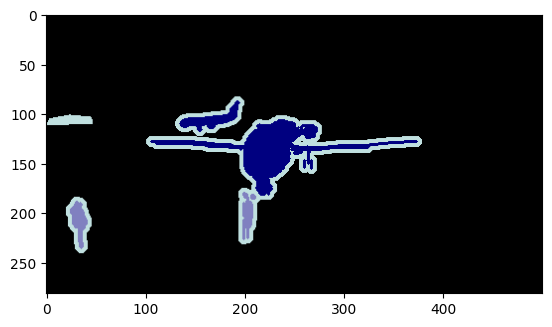

In [7]:
sample_mask = cv2.imread(mask_paths[0])
plt.imshow(sample_mask)

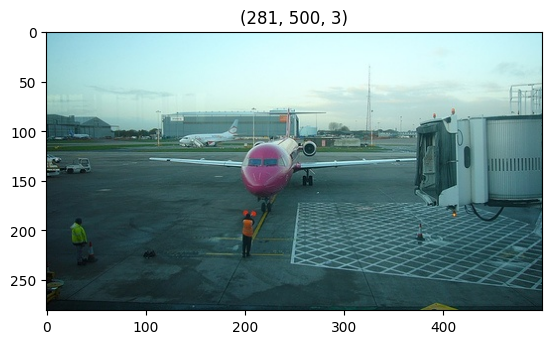

In [13]:
sample = cv2.imread(img_dir/(str(mask_paths[0].stem) + '.jpg'))
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.title(f'{sample.shape}')
plt.imshow(sample)

### 3. Preprocess data

In [14]:
# Create color map for rgb masks to identify class pixels
rgb_map = set()
for path in mask_paths[:50]:
    mask = cv2.imread(path)
    mask = mask.reshape(-1, 3)
    rgb_map.update(map(tuple, mask))

In [15]:
rgb_map

{(0, 0, 0),
 (0, 0, 64),
 (0, 0, 128),
 (0, 0, 192),
 (0, 64, 0),
 (0, 64, 128),
 (0, 128, 0),
 (0, 128, 64),
 (0, 128, 128),
 (0, 128, 192),
 (0, 192, 0),
 (0, 192, 128),
 (128, 0, 0),
 (128, 0, 64),
 (128, 0, 128),
 (128, 0, 192),
 (128, 64, 0),
 (128, 128, 0),
 (128, 128, 64),
 (128, 128, 128),
 (128, 128, 192),
 (192, 224, 224)}

In [16]:
# Note: may be different if images not read with cv2
color_dict = {
    0: (0, 0, 0), # background
    1: (0, 0, 64), # cat
    2: (0, 0, 128), # plane
    3: (0, 0, 192), # chair
    4: (0, 64, 0), # potted plant
    5: (0, 64, 128), # sheep
    6: (0, 128, 0), # bike
    7: (0, 128, 64), # cow
    8: (0, 128, 128), # bird
    9: (0, 128, 192), # dining table
    10: (0, 192, 0), # sofa
    11: (0, 192, 128), # train
    12: (128, 0, 0), # boat
    13: (128, 0, 64), # dog
    14: (128, 0, 128), # bottle
    15: (128, 0, 192), # horse
    16: (128, 64, 0), # tv/monitor
    17: (128, 128, 0), # bus
    18: (128, 128, 64), # motorbike
    19: (128, 128, 128), # car
    20: (128, 128, 192), # person
    21: (192, 224, 224) # boundary
}

categories = [
    'background',
    'cat',
    'plane',
    'chair',
    'potted plant',
    'sheep',
    'bike',
    'cow',
    'bird',
    'dining table',
    'sofa',
    'train',
    'boat',
    'dog',
    'bottle',
    'horse',
    'tv/monitor',
    'bus',
    'motorbike',
    'car',
    'person',
    'boundary'
]

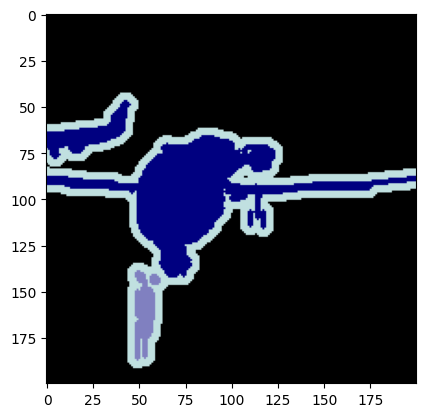

In [17]:
# Data augmentation
train_transforms = A.Compose([
    A.CenterCrop(200, 200),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.CenterCrop(200, 200),
    ToTensorV2()
])

transformed = train_transforms(image=sample, mask=sample_mask)
plt.imshow(transformed['mask'])

In [18]:
# Convert to Dataset class
class VOCDataset(Dataset):
    def __init__(self, img_dir, mask_dir, split: str, transform=None):
        self.mask_paths = self.get_mask_paths(mask_dir, split)
        self.img_dir = img_dir
        self.transforms = transform

    def __len__(self):
        return len(self.mask_paths)

    def get_mask_paths(self, mask_dir, split):
        mask_paths = list(mask_dir.glob('*.png'))
        mask_idxs = range(len(mask_paths))

        # exclude small images
        for i in reversed(mask_idxs):
            image = cv2.imread(str(mask_paths[i]))
            if image.shape[0] < 200 or image.shape[1] < 200:
                mask_paths.pop(i)

        train_size = int(len(mask_paths) * 0.8)
        val_size = (len(mask_paths) - train_size) // 2
        test_size = len(mask_paths) - train_size - val_size

        # split dataset
        if split == 'train':
            mask_paths = mask_paths[:train_size]
        elif split == 'val':
            mask_paths = mask_paths[train_size:train_size+val_size]
        else:
            mask_paths = mask_paths[train_size+val_size:]

        return mask_paths

    def __getitem__(self, index):
        img_path = self.img_dir/(str(self.mask_paths[index].stem) + '.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image, dtype=np.float32) / 255.0

        mask = cv2.imread(self.mask_paths[index])
        binary_masks = np.zeros((len(color_dict),
                                 mask.shape[0], mask.shape[1]), dtype=np.uint8) # create shape for binary mask

        for class_idx, color in color_dict.items():
            binary_masks[class_idx] = np.all(mask == color, axis=-1).astype(int)

        mask = binary_masks.argmax(axis=0)

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask

In [19]:
# Split data and Apply transforms
train_data = VOCDataset(img_dir,
                        mask_dir,
                        split='train',
                        transform=train_transforms)
val_data = VOCDataset(img_dir,
                      mask_dir,
                      split='val',
                      transform=test_transforms)
test_data = VOCDataset(img_dir,
                       mask_dir,
                       split='test',
                       transform=test_transforms)

In [13]:
len(train_data), len(val_data), len(test_data)

(2324, 290, 291)

In [20]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Create Dataloader
train_dl = DataLoader(train_data,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      shuffle=True)
val_dl = DataLoader(val_data,
                    batch_size=BATCH_SIZE,
                    num_workers=NUM_WORKERS)
test_dl = DataLoader(test_data,
                    batch_size=BATCH_SIZE,
                    num_workers=NUM_WORKERS)

In [21]:
print(f'Train: {len(train_dl)} batches of {train_dl.batch_size}')
print(f'Val: {len(val_dl)} batches of {val_dl.batch_size}')
print(f'Test: {len(test_dl)} batches of {test_dl.batch_size}')

Train: 73 batches of 32
Val: 10 batches of 32
Test: 10 batches of 32


In [22]:
image, mask = next(iter(train_dl))
image.shape, mask.shape

(torch.Size([32, 3, 200, 200]), torch.Size([32, 200, 200]))

### 4. Examine data

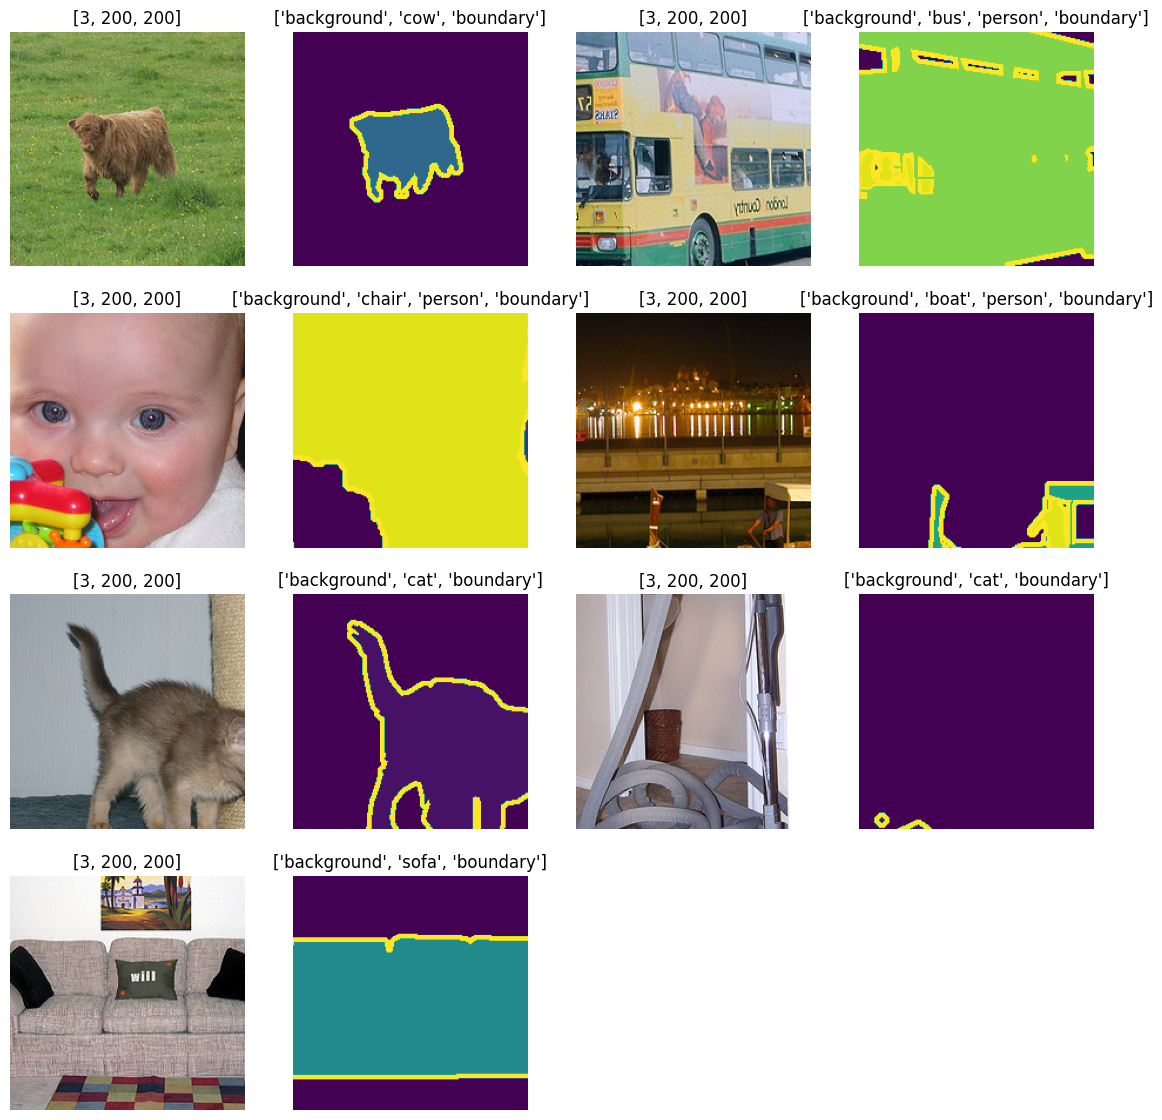

In [23]:
def plot_random_samples(dataset: torch.utils.data.Dataset, n: int, seed: int=None):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
    if n > 8:
        print('n exceeds maximum, setting n to 8')
    selected_idxs = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(14, 14))
    for i, img_idx in enumerate(selected_idxs):
        image, mask = dataset[img_idx]

        plt.subplot(4, 4, 2 * i + 1)
        plt.axis(False)
        plt.title(f'{list(image.shape)}')
        plt.imshow(image.permute(1, 2, 0))

        plt.subplot(4, 4, 2 * i + 2)
        plt.axis(False)
        plt.title(f'{[categories[c] for c in mask.unique()]}')
        plt.imshow(mask.squeeze(0))

plot_random_samples(dataset=train_data, n=7)

### 5. Transfer learning with Deeplabv3

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 186MB/s]  


In [20]:
# Freeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad=False

In [21]:
try:
    import torchinfo
except:
    !pip install -qq torchinfo

from torchinfo import summary

summary(model,
        col_names=['num_params', 'input_size', 'trainable'],
        input_size=(16, 3, 256, 256))

Layer (type:depth-idx)                             Param #                   Input Shape               Trainable
DeepLabV3                                          --                        [16, 3, 256, 256]         Partial
├─IntermediateLayerGetter: 1-1                     --                        [16, 3, 256, 256]         False
│    └─Conv2d: 2-1                                 (9,408)                   [16, 3, 256, 256]         False
│    └─BatchNorm2d: 2-2                            (128)                     [16, 64, 128, 128]        False
│    └─ReLU: 2-3                                   --                        [16, 64, 128, 128]        --
│    └─MaxPool2d: 2-4                              --                        [16, 64, 128, 128]        --
│    └─Sequential: 2-5                             --                        [16, 64, 64, 64]          False
│    │    └─Bottleneck: 3-1                        (75,008)                  [16, 64, 64, 64]          False
│    │    └─Bottlen

In [ ]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [22]:
# Rewriting classifier head to include a boundary class
model.classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 6. Writing Training Loops

In [46]:
# IoU will be used as the validation metric (Macro average)
def calc_metrics(pred_mask, actual_mask, n_samples: int, n_classes: int, device: torch.device='cpu'):
    '''For a batch of samples, takes multiclass masks for both predicted
     and actual pixel labels of the same dimensions and calculates the
     precision, recall, f1 score, and IoU
    '''
    # account for uneven splitting of batches
    if len(pred_mask) < n_samples:
        n_samples = len(pred_mask)

    epsilon = 1e-12 # prevent zero division
    precision = torch.zeros((n_samples, n_classes)).to(device)
    recall = torch.zeros((n_samples, n_classes)).to(device)
    f1 = torch.zeros((n_samples, n_classes)).to(device)
    iou = torch.zeros((n_samples, n_classes)).to(device)

    for c in range(n_classes):
        TP = ((pred_mask == c) & (actual_mask == c)).sum(dim=(1, 2)).float()
        FP = ((pred_mask == c) & (actual_mask != c)).sum(dim=(1, 2)).float()
        FN = ((pred_mask != c) & (actual_mask == c)).sum(dim=(1, 2)).float()

        precision[:, c] = TP / (TP + FP + epsilon)
        recall[:, c] = TP / (TP + FN + epsilon)
        f1[:, c] = 2 * precision[:, c] * recall[:, c] / (precision[:, c] + recall[:, c] + epsilon)
        iou[:, c] = TP / (TP + FN + FP + epsilon)

    precision = precision.mean(dim=1).mean().item()
    recall = recall.mean(dim=1).mean().item()
    f1 = f1.mean(dim=1).mean().item()
    iou = iou.mean(dim=1).mean().item()

    return precision, recall, f1, iou

In [32]:
# Test IoU function
test_image = torch.stack([train_data[0][0], train_data[1][0]]).to(device)
test_mask = torch.stack([train_data[0][1], train_data[1][1]]).to(device)

model.eval()
model.to(device)
with torch.inference_mode():
    y_logits = model(test_image)
    y_preds = y_logits['out'].softmax(dim=1).argmax(dim=1)
    precision, recall, iou, f1 = calc_metrics(pred_mask=y_preds,
                                              actual_mask=test_mask,
                                              n_samples=len(test_mask),
                                              n_classes=len(categories),
                                              device=device)

print(f'Precision {precision: .3f} | Recall {recall: .3f} | F1 score {f1: .3f} | IoU {iou: .3f}')

In [24]:
def train_step(model,
               train_dl: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer,
               l2_lambda,
               metric_fn,
               device: torch.device=None):
    train_loss, train_f1, train_iou = 0, 0, 0
    for b, (b_images, b_masks) in enumerate(train_dl):
        if device:
            b_images, b_masks = b_images.to(device), b_masks.to(device)
        model.train()
        y_logits = model(b_images)['out']
        loss = loss_fn(y_logits, b_masks)
        
        if l2_lambda:
            l2_norm = sum(w.pow(2).sum() for w in model.parameters())
            loss += l2_lambda * l2_norm
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_preds = y_logits.argmax(dim=1) # predicted multiclass mask for each batch
        _, _, f1, iou = metric_fn(pred_mask=train_preds,
                                      actual_mask=b_masks,
                                      n_samples=train_dl.batch_size,
                                      n_classes=len(categories))
        train_f1 += f1
        train_iou += iou

        if b % 24 == 0:
            print(f'Examined {(b+1) * train_dl.batch_size}/{len(train_dl.dataset)} images')

    train_loss /= len(train_dl)
    train_f1 /= len(train_dl)
    train_iou /= len(train_dl)

    return train_loss, train_f1, train_iou

In [25]:
def val_step(model,
              val_dl: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              metric_fn,
              device: torch.device=None):
    val_loss, val_f1, val_iou = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for b_images, b_masks in val_dl:
            if device:
                b_images, b_masks = b_images.to(device), b_masks.to(device)
            y_logits = model(b_images)['out']
            val_loss += loss_fn(y_logits, b_masks).item()

            val_preds = y_logits.argmax(dim=1)
            _, _, f1, iou = metric_fn(pred_mask=val_preds,
                                        actual_mask=b_masks,
                                        n_samples=val_dl.batch_size,
                                        n_classes=len(categories))
            val_f1 += f1
            val_iou += iou


        val_loss /= len(val_dl)
        val_f1 /= len(val_dl)
        val_iou /= len(val_dl)

    return val_loss, val_f1, val_iou

In [26]:
def train(model,
          epochs: int,
          train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer,
          metric_fn,
          l2_lambda: int,
          device: torch.device='cpu',
          seed: int=None):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

    if device:
        model.to(device)

    results = {'train_loss': [],
               'train_f1': [],
               'train_iou': [],
               'val_loss': [],
               'val_f1': [],
               'val_iou': []}

    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}\n------')
        train_loss, train_f1, train_iou = train_step(model, train_dl, loss_fn, optimizer, l2_lambda, metric_fn, device)
        val_loss, val_f1, val_iou = val_step(model, val_dl, loss_fn, metric_fn, device)

        print(f'Train loss {train_loss: .3f} | Train IoU {train_iou: .3f} | Val loss {val_loss: .3f} | Val IoU {val_iou: .3f}')
        results['train_loss'].append(train_loss)
        results['train_f1'].append(train_f1)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_f1'].append(val_f1)
        results['val_iou'].append(val_iou)

    return results

### 7. Fine-tune model

In [29]:
l2_lambda = 0.005
lr = 0.1
EPOCHS = 15
momentum = 0.9

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)
scheduler = ExponentialLR(optimizer, gamma=0.9)

start = timer()
results = train(model=model,
                epochs=EPOCHS,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                metric_fn=calc_metrics,
                device=device,
                seed=SEED)
print(f'<< Train time: {timer()-start} seconds >>')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0
------
Examined 16/2324 images
Examined 784/2324 images
Examined 1552/2324 images
Examined 2320/2324 images
Train loss  19.078 | Train IoU  0.058 | Val loss  0.874 | Val IoU  0.058
Epoch 1
------
Examined 16/2324 images
Examined 784/2324 images
Examined 1552/2324 images
Examined 2320/2324 images
Train loss  18.071 | Train IoU  0.061 | Val loss  0.958 | Val IoU  0.056
Epoch 2
------
Examined 16/2324 images
Examined 784/2324 images
Examined 1552/2324 images
Examined 2320/2324 images
Train loss  18.059 | Train IoU  0.061 | Val loss  0.916 | Val IoU  0.061
Epoch 3
------
Examined 16/2324 images
Examined 784/2324 images
Examined 1552/2324 images
Examined 2320/2324 images
Train loss  18.038 | Train IoU  0.062 | Val loss  0.927 | Val IoU  0.058
Epoch 4
------
Examined 16/2324 images
Examined 784/2324 images
Examined 1552/2324 images
Examined 2320/2324 images
Train loss  18.013 | Train IoU  0.063 | Val loss  0.768 | Val IoU  0.064
Epoch 5
------
Examined 16/2324 images
Examined 784/232

In [73]:
def save_model(model_path, model_state_dict, results_dict: dict):
    torch.save({
        'model': model_state_dict,
        'results': results_dict
    }, f=model_path)
    
def load_model(model_path):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    for param in model.backbone.parameters():
        param.requires_grad=False
    model.classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))
    loaded_dict = torch.load(model_path)
    model.load_state_dict(loaded_dict['model'])
    
    return model, loaded_dict['results']

# save_model('voc_seg_v1.pt', model.state_dict(), results)

In [43]:
l2_lambda = None # AdamW involves weight decay
lr = 0.1
EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=4)

start = timer()
results = train(model=model,
                epochs=EPOCHS,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                metric_fn=calc_metrics,
                device=device,
                seed=SEED)
print(f'<< Train time: {timer()-start} seconds >>')
save_model('voc_seg_v2.pt', model.state_dict(), results)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.817 | Train IoU  0.061 | Val loss  0.815 | Val IoU  0.059
Epoch 1
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.699 | Train IoU  0.065 | Val loss  0.716 | Val IoU  0.064
Epoch 2
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.654 | Train IoU  0.068 | Val loss  0.735 | Val IoU  0.064
Epoch 3
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.614 | Train IoU  0.070 | Val loss  0.750 | Val IoU  0.065
Epoch 4
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.617 | Train IoU  0.070 | Val loss  0.682 | Val IoU  0.069
Epoch 5
------
Examined 32/2324 images
Examined 800/2324 ima

In [53]:
# Reload model
loaded_model, results = load_model('/kaggle/input/voc-seg/pytorch/default/1/voc_seg_v2.pt')

### 8. Retraining with Dice Loss

In [28]:
try:
    import segmentation_models_pytorch
except:
    !pip install -qqU segmentation-models-pytorch

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [29]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
for param in model.backbone.parameters():
    param.requires_grad=False
model.classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 196MB/s]  


#### Adjusting train functions and training model

In [30]:
def train_step(model,
               train_dl: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer,
               l2_lambda,
               metric_fn,
               device: torch.device=None):
    train_loss, train_iou = 0, 0
    for b, (b_images, b_masks) in enumerate(train_dl):
        if device:
            b_images, b_masks = b_images.to(device), b_masks.to(device)
        model.train()
        y_logits = model(b_images)['out']
        loss = loss_fn(y_logits, b_masks)
        
        if l2_lambda:
            l2_norm = sum(w.pow(2).sum() for w in model.parameters())
            loss += l2_lambda * l2_norm
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tp, fp, fn, tn = smp.metrics.functional.get_stats(y_logits.argmax(1), b_masks,
                                                          mode='multiclass', num_classes=len(categories))
        iou = metric_fn(tp, fp, fn, tn, reduction='macro')
        train_iou += iou.item()

        if b % 24 == 0:
            print(f'Examined {(b+1) * train_dl.batch_size}/{len(train_dl.dataset)} images')

    train_loss /= len(train_dl)
    train_iou /= len(train_dl)

    return train_loss, train_iou

In [31]:
def val_step(model,
              val_dl: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              metric_fn,
              device: torch.device=None):
    val_loss, val_iou = 0, 0
    model.eval()

    with torch.inference_mode():
        for b_images, b_masks in val_dl:
            if device:
                b_images, b_masks = b_images.to(device), b_masks.to(device)
            y_logits = model(b_images)['out']
            val_loss += loss_fn(y_logits, b_masks).item()
            
            tp, fp, fn, tn = smp.metrics.functional.get_stats(y_logits.argmax(1), b_masks,
                                                          mode='multiclass', num_classes=len(categories))
            val_iou += metric_fn(tp, fp, fn, tn, reduction='macro').item()

        val_loss /= len(val_dl)
        val_iou /= len(val_dl)

    return val_loss, val_iou

In [32]:
def train(model,
          epochs: int,
          train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer,
          metric_fn,
          l2_lambda: int,
          device: torch.device='cpu',
          seed: int=None):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

    if device:
        model.to(device)

    results = {'train_loss': [],
               'train_iou': [],
               'val_loss': [],
               'val_iou': []}

    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}\n------')
        train_loss, train_iou = train_step(model, train_dl, loss_fn, optimizer, l2_lambda, metric_fn, device)
        val_loss, val_iou = val_step(model, val_dl, loss_fn, metric_fn, device)

        print(f'Train loss {train_loss: .3f} | Train IoU {train_iou: .3f} | Val loss {val_loss: .3f} | Val IoU {val_iou: .3f}')
        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)

    return results

In [104]:
l2_lambda = None
lr = 0.02
EPOCHS = 30

loss_fn = DiceLoss(mode='multiclass')
metric_fn = smp.metrics.functional.iou_score
optimizer = optim.AdamW(params=model.parameters(), lr=lr)

start = timer()
results = train(model=model,
                epochs=EPOCHS,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                metric_fn=metric_fn,
                device=device,
                seed=SEED)
print(f'<< Train time: {timer()-start} seconds >>')
save_model('voc_seg_v3.pt', model.state_dict(), results)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.463 | Train IoU  0.364 | Val loss  0.351 | Val IoU  0.494
Epoch 1
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.371 | Train IoU  0.446 | Val loss  0.349 | Val IoU  0.517
Epoch 2
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.354 | Train IoU  0.454 | Val loss  0.322 | Val IoU  0.536
Epoch 3
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.341 | Train IoU  0.477 | Val loss  0.334 | Val IoU  0.528
Epoch 4
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.323 | Train IoU  0.501 | Val loss  0.315 | Val IoU  0.548
Epoch 5
------
Examined 32/2324 images
Examined 800/2324 ima

In [109]:
l2_lambda = None
lr = 0.005
EPOCHS = 10

loss_fn = DiceLoss(mode='multiclass')
metric_fn = smp.metrics.functional.iou_score
optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.001)

start = timer()
results = train(model=model,
                epochs=EPOCHS,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                metric_fn=metric_fn,
                device=device,
                seed=SEED)
print(f'<< Train time: {timer()-start} seconds >>')
save_model('voc_seg_v4.pt', model.state_dict(), results)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.194 | Train IoU  0.598 | Val loss  0.249 | Val IoU  0.599
Epoch 1
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.202 | Train IoU  0.623 | Val loss  0.245 | Val IoU  0.601
Epoch 2
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.194 | Train IoU  0.616 | Val loss  0.247 | Val IoU  0.601
Epoch 3
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.190 | Train IoU  0.629 | Val loss  0.248 | Val IoU  0.602
Epoch 4
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.188 | Train IoU  0.634 | Val loss  0.252 | Val IoU  0.590
Epoch 5
------
Examined 32/2324 images
Examined 800/2324 ima

In [56]:
model3, results3 = load_model('/kaggle/input/voc-seg-2/pytorch/default/1/voc_seg_v3.pt')
model4, results4 = load_model('/kaggle/input/voc-seg-2/pytorch/default/1/voc_seg_v4.pt')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_36/1473641509.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

In [57]:
l2_lambda = None
lr = 0.001
EPOCHS = 10

loss_fn = DiceLoss(mode='multiclass')
metric_fn = smp.metrics.functional.iou_score
optimizer = optim.AdamW(params=model4.parameters(), lr=lr, weight_decay=0.001)

start = timer()
results = train(model=model4,
                epochs=EPOCHS,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                metric_fn=metric_fn,
                device=device,
                seed=SEED)
print(f'<< Train time: {timer()-start} seconds >>')
save_model('voc_seg_v5.pt', model4.state_dict(), results)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.194 | Train IoU  0.626 | Val loss  0.189 | Val IoU  0.713
Epoch 1
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.189 | Train IoU  0.647 | Val loss  0.189 | Val IoU  0.703
Epoch 2
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.190 | Train IoU  0.635 | Val loss  0.191 | Val IoU  0.711
Epoch 3
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.188 | Train IoU  0.627 | Val loss  0.190 | Val IoU  0.712
Epoch 4
------
Examined 32/2324 images
Examined 800/2324 images
Examined 1568/2324 images
Examined 2336/2324 images
Train loss  0.181 | Train IoU  0.629 | Val loss  0.189 | Val IoU  0.712
Epoch 5
------
Examined 32/2324 images
Examined 800/2324 ima

### 9. Evaluating model

In [85]:
model5, results5 = load_model('/kaggle/input/voc-seg-4/pytorch/default/1/voc_seg_v5.pt')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/tmp/ipykernel_36/1473641509.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load

In [86]:
# Evaluate test set
test_loss, test_iou = val_step(model5.to(device), test_dl, loss_fn, metric_fn, device)
print(f'Test loss {test_loss} | Test IoU {test_iou} | Test F1 score {1 - test_loss}')

Test loss 0.15946322195231916 | Test IoU 0.7348426222801209 | Test F1 score 0.8405367780476809


n exceeds maximum; setting n to 5


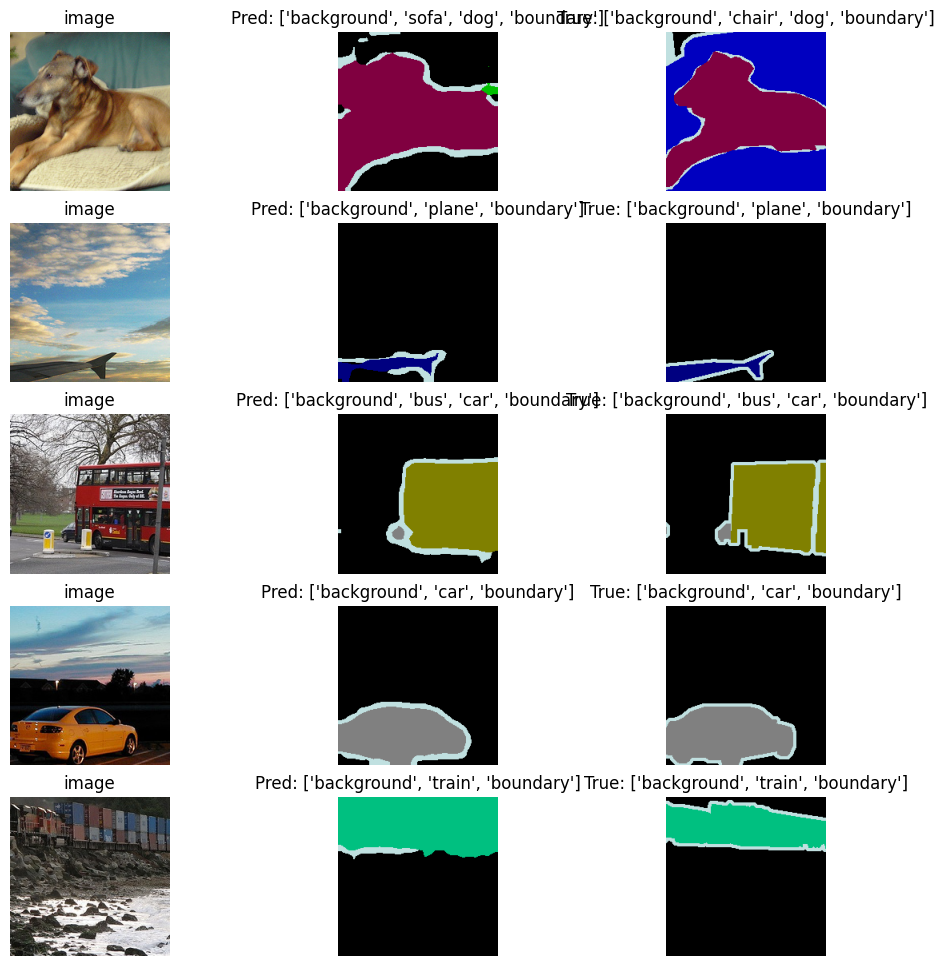

In [89]:
def to_rgb_mask(mask, rgb_map, n_classes):
    rgb_mask = torch.zeros((mask.shape[0], mask.shape[1], 3), dtype=torch.int)
    for c, rgb in rgb_map.items():
        for row in range(mask.shape[0]):
            for col in range(mask.shape[1]):
                if c == mask[row][col]:
                    rgb_mask[row][col][0] = rgb[0]
                    rgb_mask[row][col][1] = rgb[1]
                    rgb_mask[row][col][2] = rgb[2]
        
    return rgb_mask

def make_plot_predictions(model, dataset, n, device: torch.device='cpu', seed: int=None):
    if n > 5:
        print('n exceeds maximum; setting n to 5')
        n = 5
    if seed:
        random.seed(seed)
        
    selected_idxs = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(12, 12))
    
    model.eval()
    model.to(device)
    
    for i, img_idx in enumerate(selected_idxs):
        with torch.inference_mode():
            image, mask = dataset[img_idx]
            image, mask = image.to(device), mask
            y_logits = model(image.unsqueeze(0))['out']
            y_mask = y_logits[0].argmax(0)
            rgb_pred_mask = to_rgb_mask(y_mask, color_dict, len(categories))
            rgb_mask = to_rgb_mask(mask, color_dict, len(categories))
            
            plt.subplot(5, 3, 3*i + 1)
            plt.imshow(image.cpu().permute(1,2,0))
            plt.axis(False)
            plt.title('image')
            
            plt.subplot(5, 3, 3*i + 2)
            plt.imshow(rgb_pred_mask.cpu())
            pred_labels = [categories[c] for c in y_mask.unique()]
            plt.axis(False)
            plt.title(f'Pred: {pred_labels}')
            
            plt.subplot(5, 3, 3*i + 3)
            plt.imshow(rgb_mask)
            actual_labels = [categories[c] for c in mask.unique()]
            plt.axis(False)
            plt.title(f'True: {actual_labels}')
            
make_plot_predictions(model5, test_data, n=9, device=device)

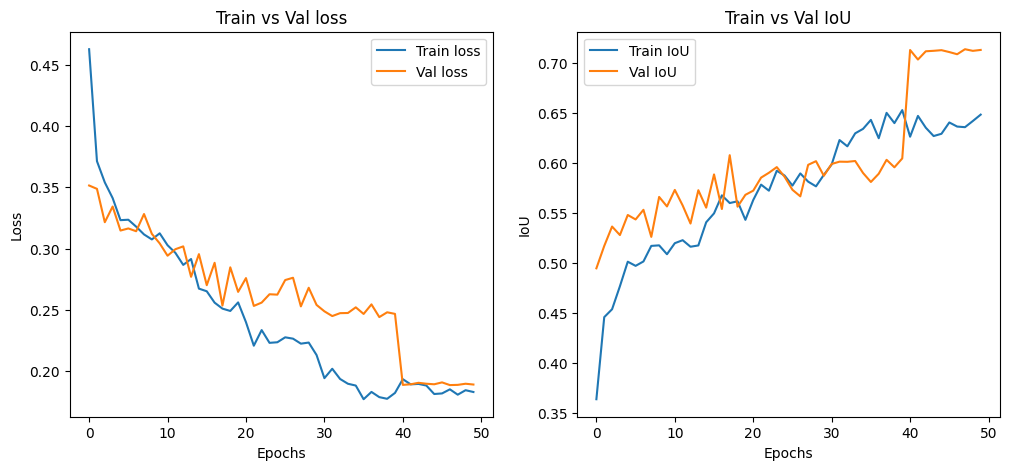

In [87]:
def plot_results(results: dict):
    plt.figure(figsize=(12, 5))
    epochs=len(results['train_loss'])

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), results['train_loss'], label='Train loss')
    plt.plot(range(epochs), results['val_loss'], label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Val loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), results['train_iou'], label='Train IoU')
    plt.plot(range(epochs), results['val_iou'], label='Val IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('Train vs Val IoU')

for key, item in results4.items():
    results3[key] += item
for key, item in results5.items():
    results3[key] += item
plot_results(results3)